# Wczytanie i przygotowanie danych

Dane są obrabiane w identyczny sposób jak na poprzednich zajęciach.

In [2]:
import numpy as np
import pandas as pd
import itertools as it
import random
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Categorical

x_and_y_train = pd.concat([pd.read_csv('/home/ml/data/xtrain_1.csv', 
                                       low_memory=False),
                           pd.read_csv('/home/ml/data/xtrain_2.csv', 
                                       low_memory=False),
                           pd.read_csv('/home/ml/data/y_train.csv', 
                                       header=None, names=['y'])],
                          axis=1)

x_and_y_train['received_at'] = pd.to_datetime(x_and_y_train['received_at'])

x_and_y_train = x_and_y_train.sort_values('received_at')

ytrain = x_and_y_train.pop('y')
xtrain = x_and_y_train

low_card_cat_colnames = [
                    'agent_type', 'bin_country', 'browser', 'browser_string_mismatch',
                    'card_brand', 'card_level', 'card_type', 'cc_bin_number_brand', 'cc_bin_number_type',
                    'cc_number_hash_assert_history', 'cc_number_hash_result', 'input_ip_assert_history',
                    'input_ip_geo', 'input_ip_result', 'js_browser', 'js_fonts_number', 'js_os', 'navigatorplatform',
                    'os', 'remote_desktop', 'request_result', 'review_status', 'x10047', 'x12050', 'x16453', 
                    'x21202', 'x21215', 'x21877', 'x26431', 'x32520', 'x39150', 'x41009', 'x5170', 'x5193',
                    'x5290', 'x5342', 'x55586', 'x66439', 'x70617', 'x72496', 'x73629', 'x80025', 'x80385',
                    'x80911', 'x83032', 'x83336', 'x91746', 'x92645', 'x96255', 
                   ]
                    
                    
high_card_cat_colnames = [
                    'bin', 'browser_string_hash', 'cc_bin_number', 'cc_bin_number_category', 'cc_bin_number_geo',
                    'cc_bin_number_org', 'country_code', 'dns_ip_city', 'dns_ip_isp', 'dns_ip_organization',
                    'dns_ip_region', 'input_ip_city', 'js_browser_string_hash', 'js_fonts_hash', 'language',
                    'mime_type_hash', 'name', 'user_ip_country', 'x12964', 'x18591', 'x2801', 'x30901', 'x33709',
                    'x46567', 'x46591', 'x52094', 'x55037', 'x61305', 'x63143', 'x66015', 'x76585', 'x82598',
                    'x87611', 'x92166', 'x92221', 'x94347', 
                    ]
                    
parsable_cat_colnames = [
                    'browser_string', 'headers_accept_encoding', 'headers_accept_language', 'headers_user_agent',
                    'input_ip_attributes', 'js_browser_string', 'navigatorappversion', 'useragent', 'x31255',
                    'x50315', 
                    ]
                    
degree_cat_colnames = ['risk_rating']
                    
castable_to_numeric_cat_colnames = [
                    'x23739', 'x3314', 'x42317', 'x43300', 'x44170', 'x48420', 'x51274', 'x54084',
                    'x5600', 'x59752', 'x60781', 'x87918', 'x9486', 'x97674', 'x98509',
                    'application_id'
                    ]


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import category_encoders as ce

from hash_transformers import SimplisticHasher

def undict_one_col(df, colname):
    column = df.pop(colname)
    values = [dict() if x is None else x for x in column]
    unpacked_columns = pd.DataFrame.from_dict(values)
    unpacked_columns = unpacked_columns.add_prefix(colname + '_')
    return pd.concat([df, unpacked_columns], axis=1)

def undict_cols(df, col_names):
    for col_name in col_names:
        df = undict_one_col(df, col_name)    
    return df

DF_cat = xtrain[low_card_cat_colnames+high_card_cat_colnames]
cat_colnames = DF_cat.columns.tolist()

dict_counts = xtrain.apply(lambda col: col.apply(lambda x: isinstance(x, dict))).sum()
dict_colnames = dict_counts[dict_counts>0].index.tolist()

xtrain_undicted = undict_cols(xtrain[dict_colnames], dict_colnames)
xtrain_undicted_numeric = xtrain_undicted.select_dtypes(include=[np.number])

DF_cat_and_undict = pd.concat([DF_cat, xtrain_undicted_numeric], axis=1)
cat_colnames = DF_cat_and_undict.select_dtypes(exclude=[np.number]).columns.tolist()

DF_cat_and_undict.fillna((-999), inplace=True)

/data/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# XGBoost

## Zasada działania

XGBoost buduje w pierwszym kroku zwykłe drzewo klasyfikacyjne jak w algorytmie random forest. Następnie dodaje kolejne drzewa regresyjne tak, aby modyfikując wyniki dla poszczególnych obserwacji zmniejszać funkcję straty korzystając z algorytmu spadku po gradiencie (jak w przypadku sieci neuronowych i regresji logistycznej). Kolejne drzewa są uczone sekwencyjnie, więc możliwości zrównoleglenia algorytmu są ograniczone.


<br>
<br>
<div style="text-align: center"> **Pojedyncze drzewo** </div>
<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png" width="600" height="300">
<br>
<br>
<div style="text-align: center"> **XGBoost** </div>
<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png" width="600" height="300">
<br>
<br>

## Parametry:

max_depth : int - 
Maksymalna głębokość pojedynczego drzewa.
    
learning_rate : float - 
learning rate (,,eta'')

n_estimators : int - 
Liczba drzew.

gamma : float - 
Minimalna redukcja funkcji straty wymagana do wykonania podziału węzła.

subsample : float - 
Jaka część danych ma być samplowana do budowy pojedynczego drzewa.

colsample_bytree : float - 
Jaki podzbiór kolumn ma być losowany podczas uczenia pojedynczego drzewa.

colsample_bylevel : float - 
Jaki podzbiór kolumna ma być losowany podczas pojedynczego podziału w węźle.

scale_pos_weight : float - 
Stosunek wag dla klas 1 i 0.

/data/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


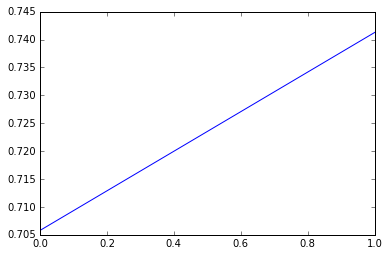

In [4]:
pipe = Pipeline([
    ('simplistic_hash', SimplisticHasher(cols=cat_colnames)),
    ('xgb', XGBClassifier(
                max_depth=3, 
                learning_rate=0.1, 
                n_estimators=100, 
                gamma=0, 
                subsample=1, 
                colsample_bytree=1, 
                colsample_bylevel=1, 
                scale_pos_weight=1, 
            )
    ),
])

scores = cross_val_score(pipe,
                         DF_cat_and_undict,
                         ytrain,
                         scoring='roc_auc',
                         cv=TimeSeriesSplit(2))

plt.plot(scores)

# Optymalizacja Hiperparametrów

**Grid Search** - Przeszukiwanie całej przestrzeni parametrów po równomiernie rozłożonej siatce.

**Random Search** - Przeszukiwanie całej przestrzeni parametrów w sposób losowy.
<br>
<img src="http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2015/07/scikitlearn8.jpeg" height="400" width="800">


**Optymalizacja Bayesowska** - Przeszukiwanie przestrzeni parametrów oparte funkcję oczekiwanego zysku estymowaną przy pomocy procesów gaussowskich.
<img src="https://advancedoptimizationatharvard.files.wordpress.com/2014/04/capture.png" height="2000" width="700">
<br>
<img src="https://thuijskens.github.io/images/2016_12_29/real_loss_contour.png" height="400" width="500">
<br>
<img src="https://thuijskens.github.io/images/2016_12_29/bo_2d_new_data.gif" height="2000" width="500">

## Definicje funkcji

Kod funkcji pochodzi z bardzo ciekawego artykułu porównującego różne metody i silniki do optymalizacji hiperparametrów: 
[Optimizing the hyperparameter of...](https://roamanalytics.com/2016/09/15/optimizing-the-hyperparameter-of-which-hyperparameter-optimizer-to-use/)

In [5]:
def random_search(
        X_train, y_train, model_class, param_grid, loss, sampsize=None):
    """
    Random search over the grid defined by `param_grid`.
    Parameters
    ----------
    X_train : np.array
        The design matrix, dimension `(n_samples, n_features)`.
    y_train : list or np.array
        The target, of dimension `n_samples`.
    model_class : classifier
        A classifier model in the mode of `sklearn`, with at least
        `fit` and `predict` methods operating on things like
        `X` and `y`.
    param_grid : dict
        Map from parameter names to lists of appropriate values
        for that parameter. This is not the expanded grid, but
        rather the simple map that can be expanded by `expand_grid`
        below. This method performs the expansion.
    loss : function or string
        An appropriate loss function or string recognizable by
        sklearn.cross_validation.cross_val_score. In sklearn, scores
        are positive and losses are negative because they maximize,
        but here we are minimizing so we always want smaller to mean
        better.
    sampsize : int or None
        Number of samples to take from the grid. If `None`, then
        `sampsize` is half the size of the full grid.
    Returns
    -------
    list of dict
        Each has keys 'loss' and 'params', where 'params' stores the
        values from `param_grid` for that run. The primary organizing
        value is 'loss'.
    Example
    -------
    >>> param_grid = {
            'max_depth' : [4, 8],
            'learning_rate' : [0.01, 0.3],
            'n_estimators' : [20, 50],
            'objective' : ['multi:softprob'],
            'gamma' : [0, 0.25],
            'min_child_weight' : [1],
            'subsample' : [1],
            'colsample_bytree' : [1]}
    >>> res = random_search(X, y, XGBClassifier, param_grid, LOG_LOSS)
    To be followed by (see below):
    >>> best_params, best_loss = best_results(res)
    """
    exapnded_param_grid = expand_grid(param_grid)
    if sampsize == None:
        sampsize = int(len(exapnded_param_grid) / 2.0)
    samp = random.sample(exapnded_param_grid, sampsize)
    results = []
    for params in samp:
        err = cross_validated_scorer(
            X_train, y_train, model_class, params, loss)
        results.append({'loss': err, 'params': params})
    return results


def grid_search(X_train, y_train, model_class, param_grid, loss, sampsize=1000000):
    """
    Full grid search over the grid defined by `param_grid`.
    Parameters
    ----------
    X_train : np.array
        The design matrix, dimension `(n_samples, n_features)`.
    y_train : list or np.array
        The target, of dimension `n_samples`.
    model_class : classifier
        A classifier model in the mode of `sklearn`, with at least
        `fit` and `predict` methods operating on things like
        `X` and `y`.
    param_grid : dict
        Map from parameter names to lists of appropriate values
        for that parameter. This is not the expanded grid, but
        rather the simple map that can be expanded by `expand_grid`
        below. This method performs the expansion.
    loss : function or string
        An appropriate loss function or string recognizable by
        sklearn.cross_validation.cross_val_score. In sklearn, scores
        are positive and losses are negative because they maximize,
        but here we are minimizing so we always want smaller to mean
        better.
    Returns
    -------
    list of dict
        Each has keys 'loss' and 'params', where 'params' stores the
        values from `param_grid` for that run. The primary organizing
        value is 'loss'.
    Example
    -------
    >>> param_grid = {
            'max_depth' : [4, 8],
            'learning_rate' : [0.01, 0.3],
            'n_estimators' : [20, 50],
            'objective' : ['multi:softprob'],
            'gamma' : [0, 0.25],
            'min_child_weight' : [1],
            'subsample' : [1],
            'colsample_bytree' : [1]}
    >>> res = grid_search(X, y, XGBClassifier, param_grid, LOG_LOSS)
    To be followed by (see below):
    >>> best_params, best_loss = best_results(res)
    """
    results = []
    expanded_param_grid = expand_grid(param_grid)
    print "Number of iterations: ", len(expanded_param_grid)
    counter = 0
    for params in expanded_param_grid:
        err = cross_validated_scorer(
            X_train, y_train, model_class, params, loss)
        results.append({'loss': err, 'params': params})
        counter += 1
        if counter > sampsize:
            break
    return results


def expand_grid(param_grid):
    """
    Expand `param_grid` to the full grid, as a list of dicts.
    Parameters
    ----------
    param_grid : dict
        Map from parameter names to lists of appropriate values
        for that parameter. This is not the expanded grid, but
        rather the simple map that can be expanded by `expand_grid`
        below. This method performs the expansion.
    Returns
    -------
    list of dict
        If `param_grid` was
        {'foo': [1,2], 'bar': [3,4]}
        Then the return value would be
        [{'foo': 1, 'bar': 3},  {'foo': 1, 'bar': 4},
         {'foo': 2, 'bar': 3},  {'foo': 2, 'bar': 4}]
    """        
    varNames = sorted(param_grid)
    return [dict(zip(varNames, prod))
            for prod in it.product(*(param_grid[varName]
                                     for varName in varNames))]


def cross_validated_scorer(
        X_train, y_train, model_class, params, loss, kfolds=5):
    """
    The scoring function used through this module, by all search
    functions.
    Parameters
    ----------
    X_train : np.array
        The design matrix, dimension `(n_samples, n_features)`.
    y_train : list or np.array
        The target, of dimension `n_samples`.
    model_class : classifier
        A classifier model in the mode of `sklearn`, with at least
        `fit` and `predict` methods operating on things like
        `X` and `y`.
    params : dict
        Map from parameter names to single appropriate values
        for that parameter. This will be used to build a model
        from `model_class`.
    loss : function or string
        An appropriate loss function or string recognizable by
        sklearn.cross_validation.cross_val_score. In sklearn, scores
        are positive and losses are negative because they maximize,
        but here we are minimizing so we always want smaller to mean
        better.
    kfolds : int
        Number of cross-validation runs to do.
    Returns
    -------
    float
       Average loss over the `kfolds` runs.
    """
    print "*",
    mod = model_class(**params)
    cv_score = -1 * cross_val_score(
        mod,
        X_train,

        y=y_train,
        scoring=loss,
        cv=kfolds,
        n_jobs=1).mean()
    return cv_score


def skopt_search(
        X_train, y_train, model_class, param_grid, loss, skopt_method, n_calls=100):
    """
    General method for applying `skopt_method` to the data.
    Parameters
    ----------
    X_train : np.array
        The design matrix, dimension `(n_samples, n_features)`.
    y_train : list or np.array
        The target, of dimension `n_samples`.
    model_class : classifier
        A classifier model in the mode of `sklearn`, with at least
        `fit` and `predict` methods operating on things like
        `X` and `y`.
    param_grid : dict
        Map from parameter names to pairs of values specifying the
        upper and lower ends of the space from which to sample.
        The values can also be directly specified as `skopt`
        objects like `Categorical`.
    loss : function or string
        An appropriate loss function or string recognizable by
        sklearn.cross_validation.cross_val_score. In sklearn, scores
        are positive and losses are negative because they maximize,
        but here we are minimizing so we always want smaller to mean
        better.
    skopt_method : skopt function
        Can be `gp_minimize`, `forest_minimize`, or `gbrt_minimize`.
    n_calls : int
        Number of evaluations to do.
    Returns
    -------
    list of dict
        Each has keys 'loss' and 'params', where 'params' stores the
        values from `param_grid` for that run. The primary organizing
        value is 'loss'.
    """
    param_keys, param_vecs = zip(*param_grid.items())
    param_keys = list(param_keys)
    param_vecs = list(param_vecs)

    def skopt_scorer(param_vec):
        params = dict(zip(param_keys, param_vec))
        err = cross_validated_scorer(
            X_train, y_train, model_class, params, loss)
        return err
    outcome = skopt_method(skopt_scorer, list(param_vecs), n_calls=n_calls)
    results = []
    for err, param_vec in zip(outcome.func_vals, outcome.x_iters):
        params = dict(zip(param_keys, param_vec))
        results.append({'loss': err, 'params': params})
    return results

## Porównanie metod optymalizacji hiperparametrów

In [25]:
def plot_opt(res, label=None):
    losses = [x['loss'] for x in res]
    return plt.plot([min(losses[:i]) for i in range(1,len(losses) + 1)], label=label)
    

pipe = Pipeline([
    ('simplistic_hash', SimplisticHasher(cols=cat_colnames)),
])

x_train = pipe.fit_transform(DF_cat_and_undict)

max_iter = 50

### Grid Search

In [7]:
param_grid = {
            'max_depth' : range(1, 20),
            'learning_rate' : np.arange(0.01, 0.1, 0.01),
            'n_estimators' : range(1, 10),
            'min_child_weight' : np.arange(0.5, 1., 0.1),
            'subsample' : np.arange(0.5, 1., 0.1),
            'colsample_bytree' : np.arange(0.5, 1., 0.1)}

res_grid = grid_search(x_train,
                      ytrain,
                      XGBClassifier,
                      param_grid,
                      'neg_log_loss',
                      sampsize=max_iter)


Number of iterations:  192375
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


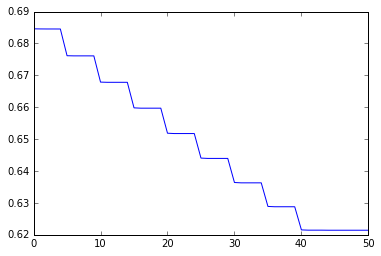

In [8]:
plot_opt(res_grid)

### Random Search

In [9]:
param_grid = {
            'max_depth' : range(1, 20),
            'learning_rate' : np.arange(0.01, 0.1, 0.01),
            'n_estimators' : range(1, 10),
            'min_child_weight' : np.arange(0.5, 1., 0.1),
            'subsample' : np.arange(0.5, 1., 0.1),
            'colsample_bytree' : np.arange(0.5, 1., 0.1)}
res_random = random_search(x_train,
                      ytrain, 
                      XGBClassifier, 
                      param_grid, 
                      'neg_log_loss',
                      sampsize=max_iter)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


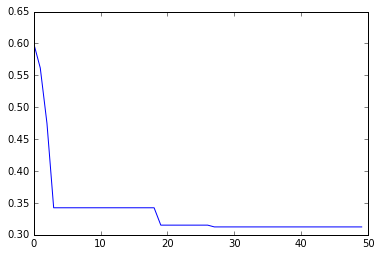

In [10]:
plot_opt(res_random)

### Optymalizacja Bayesowska

In [11]:
# skopt_grid = {
#             'max_depth': (1, 30),
#             'learning_rate': (0.01, 1.),
#             'n_estimators': (1, 200),
#             'gamma': (0., 5.),
#             'min_child_weight': (0, 10.),
#             'subsample': (0.1, 1),
#             'colsample_bytree': (0.1, 1)}

skopt_grid = {
            'max_depth': (1, 20),
            'learning_rate': (0.01, 0.1),
            'n_estimators': (1, 10),
#            'objective' : Categorical(('binary:logistic',)),
            'min_child_weight': (0.5, 1.),
            'subsample': (0.5, 1.),
            'colsample_bytree': (0.5, 1.)}



res_skopt = skopt_search(x_train,
                      ytrain, 
                      XGBClassifier, 
                      skopt_grid, 
                      'neg_log_loss',
                      gp_minimize, 
                      n_calls=max_iter)

* * * * * * * * * * * * * * * * * * * * * * * * * * *

/data/anaconda2/lib/python2.7/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


 * * * * * * * * * * * * * * * * * * * * * * *


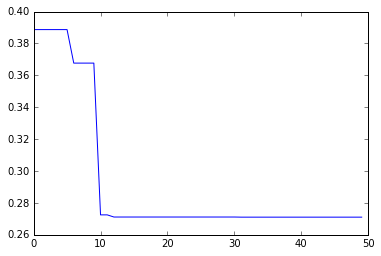

In [26]:
plot_opt(res_skopt)

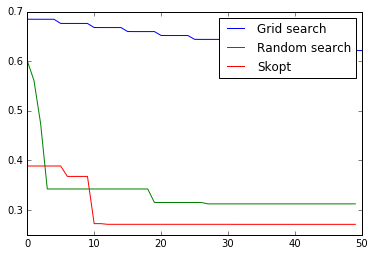

In [27]:
plot_opt(res_grid, 'Grid search')
plot_opt(res_random, 'Random search')
plot_opt(res_skopt, 'Skopt')
plt.legend()

# Odnośniki

#### XGBoost
http://xgboost.readthedocs.io/en/latest/model.html - dokumentacja XGBoost

https://arxiv.org/abs/1603.02754 - artykuł o XGBoost

#### Skopt
https://scikit-optimize.github.io/ - reopzytorium projektu

#### Optymalizacja Bayesowska
https://roamanalytics.com/2016/09/15/optimizing-the-hyperparameter-of-which-hyperparameter-optimizer-to-use/ - optymalizacja hiperparametrów - post

https://www.youtube.com/watch?v=YB64VoGQsK8 - wykład o optymalizacji bayesowskiej